# MindAudio数据处理快速入门

## 1.数据处理API结构总览
依据不同功能将数据处理API分为如下六类：

     ───── mindaudio.data
    │
    │  ├── mindaudio.data.io
    │  │   └─ read、write等音频文件读写API
    │  │
    │  ├── mindaudio.data.features
    │  │   └─ fbank、mfcc等音频特征提取API
    │  │
    │  ├── mindaudio.data.filters
    │  │   └─ low_pass_filter、notch_filter等滤波器
    │  │
    │  ├── mindaudio.data.augment
    │  │   └─ add_noise、add_reverb等数据增强API
    │  │
    │  ├── mindaudio.data.processing
    │  │   └─ normalize、clip等信号时域处理API
    │  │
    └──└── mindaudio.data.spectrum
           └─ stft、melspectrogram等信号频谱信息获取API 
    

## 2.快速体验
各类API中挑选出典型样例进行演示：

### 2.1.  mindaudio.data.io:音频文件读写

#### mindaudio.data.io.read
目前只支持.wav格式文件的读取，支持读取双声道和单声道音频

number of channels = 2
length = 0.01s


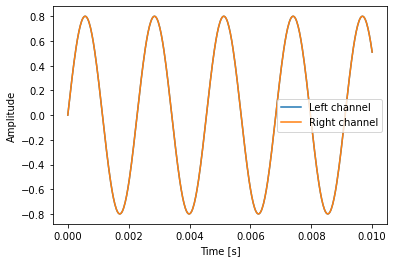

In [1]:
import os
import mindaudio
import scipy.io

# Get a multi-channel audio file from the tests/data directory.
data_dir = os.path.join(os.path.dirname(scipy.io.__file__), "tests", "data")
wav_fname = os.path.join(data_dir, "test-44100Hz-2ch-32bit-float-be.wav")

# Load the .wav file contents.
audio, sr = mindaudio.read(wav_fname)
print(f"number of channels = {audio.shape[1]}")

length = audio.shape[0] / sr
print(f"length = {length}s")

# Plot the waveform.
import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, audio.shape[0])
plt.plot(time, audio[:, 0], label="Left channel")
plt.plot(time, audio[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

####  mindaudio.data.io.write
支持多声道文件写入，输出文件为.wav格式

In [2]:
import numpy as np
import mindaudio

samplerate = 44100
fs = 100
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)
mindaudio.write("example.wav", data, samplerate)

### 2.2 mindaudio.data.features:音频特征提取

####  mindaudio.data.features.fbank
支持[time],[batch, time] 及 [batch, channel, time]形式的数据特征提取

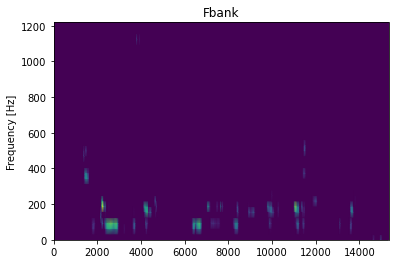

In [3]:
import numpy as np
import mindaudio

test_data, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
# Carry out data feature extraction
n_fft = 512
matrix = mindaudio.fbank(test_data, n_fft=n_fft)
data_shape = matrix.shape

# Drawing display
x = [i for i in range(0, (data_shape[0]+1)*data_shape[1], data_shape[0]+1)]
f = [i/n_fft * sr for i in range(0, int(data_shape[0]))]
plt.pcolormesh(x,f,matrix, shading='gouraud', vmin=0)
plt.title('Fbank')
plt.ylabel('Frequency [Hz]')
plt.show()

### 2.3 mindaudio.data.filters:各类滤波器

####  mindaudio.data.filters.low_pass_filter
低通滤波器：阻断高频信号，支持多声道信号输入

In [4]:
import mindaudio
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

audio, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
ipd.display(ipd.Audio(audio, rate=sr))

cutoff_freq = 1000
out_waveform = mindaudio.low_pass_filter(audio, sr, cutoff_freq)
ipd.display(ipd.Audio(out_waveform, rate=sr))

### 2.4 mindaudio.data.augment：数据增强

#### mindaudio.data.augment.add_noise
加噪：支持[time],[batch, time] 及 [batch, channel, time]形式的输入，以下案例以一维数据为例展示效果。

In [5]:
import mindaudio
import IPython.display as ipd

samples, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
ipd.display(ipd.Audio(samples, rate=sr))
background_list = ["../tests/samples/ASR/BAC009S0002W0123.wav"]

# test add noise for 1d
noisy_wav = mindaudio.add_noise(samples, background_list, 3, 30, 1.0)
# display
ipd.display(ipd.Audio(noisy_wav, rate=sr))

#### mindaudio.data.augment.add_reverb
加混响，模拟室内音效：支持[time],[batch, time] 及 [batch, channel, time]形式的输入,以下案例以一维数据为例展示效果。

In [7]:
import mindaudio
import IPython.display as ipd

samples, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
ipd.display(ipd.Audio(samples, rate=sr))
rir_list = ["../tests/samples/rir/air_binaural_aula_carolina_0_1_1_90_3_16k.wav"]

# test add reverb for 1d
rir_wav = mindaudio.add_reverb(samples, rir_list, 1.0)
# display
ipd.display(ipd.Audio(rir_wav, rate=sr))

### 2.5 mindaudio.data.processing：时域信号处理

#### mindaudio.data.processing.resample
重采样：改变信号采样率

In [8]:
import mindaudio

waveform = np.random.random([1, 441000])
y_8k = mindaudio.resample(waveform, orig_freq=44100, new_freq=16000)
print(waveform.shape)
print(y_8k.shape)

(1, 441000)
(1, 160000)


#### mindaudio.data.processing.clip
依据给定起始位置以及长度裁剪信号

In [9]:
import mindaudio

waveform, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
ipd.display(ipd.Audio(waveform, rate=sr))

offset_factor = 0.2
duration_factor = 0.3
# do clip
out_waveform = mindaudio.clip(waveform, offset_factor, duration_factor)
ipd.display(ipd.Audio(out_waveform, rate=sr))

### 2.6 mindaudio.data.spectrum：信号频谱信息获取

#### mindaudio.data.spectrum.stft
对原始信号做短时傅立叶变换，n_fft决定频率的分辨率

In [10]:
import mindaudio

# Read audio file
test_data, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
# Carry out data feature extraction
n_fft = 512
matrix = mindaudio.stft(test_data, n_fft=n_fft)
print(matrix.shape)

(257, 750)


#### mindaudio.data.spectrum.magphase
获取信号复值谱图的幅度与相位

(257, 750)


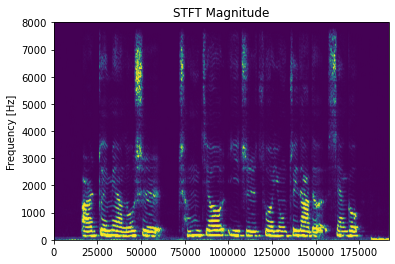

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import mindaudio

# Read audio file
test_data, sr = mindaudio.read("../tests/samples/ASR/BAC009S0002W0122.wav")
# Carry out data feature extraction
n_fft = 512
matrix = mindaudio.stft(test_data, n_fft=n_fft)
magnitude, _ = mindaudio.magphase(matrix, 1)
print(magnitude.shape)
# Drawing display
x = [i for i in range(0, int(n_fft/2*magnitude.shape[1]), int(n_fft/2))]
f = [i/n_fft * sr for i in range(0, int(n_fft/2+1))]
plt.pcolormesh(x,f,magnitude, shading='gouraud', vmin=0, vmax=np.percentile(magnitude, 98))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.show()